# $z < 0.4$

In [305]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import emcee
import corner
import scipy.stats as stats

import sys
sys.path.append("../")
from pyACC.cosmology import Dc_w0waCDM

### Hubble Function

In [306]:
H0=68
Omega_r=0
def hubble_function(z,Omega_m,Omega_r,w0,wa,H0):
    return H0*np.sqrt(Omega_m*(1+z)**3+Omega_r*(1+z)**4+(1-Omega_m-Omega_r)*(1+z)**(3*(1+w0+wa))*np.exp(-3*wa*z/(1+z)))

### File

In [307]:
file_path = 'lcparam_full_long.txt'

with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

z_data = data['zcmb'].values
mb = data['mb'].values #B-band peak magnitude
dmb = data['dmb'].values

Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

### Distance Modulus

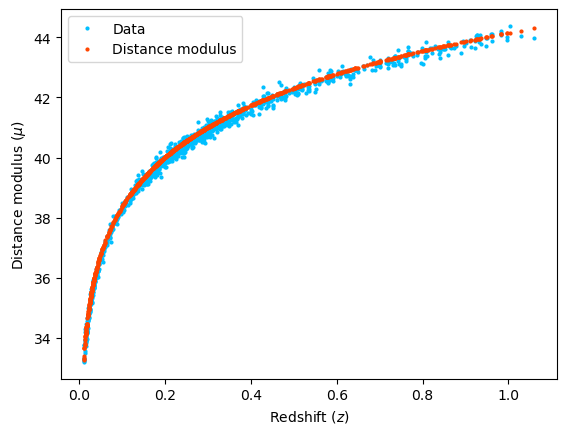

In [308]:
def get_mu(z,H0,Omega_r,Omega_m,w0,wa):
    comoving_distance=[]
    distance_modulus=[]

    for i in range(len(z)):
        comoving_distance.append(Dc_w0waCDM(hubble_function,z[i],Omega_r,Omega_m,w0,wa,H0))
        distance_modulus.append(5*np.log10(comoving_distance[i]*(1+z[i]))+25)
    return np.array(distance_modulus)

#distance modulus of the data: mu_data=mb-M with M the absolute magnitude of a type Ia supernova, so M=-19.3
M=-19.3
mu_data=mb-M

plt.plot(z_data,mu_data,'o',markersize=2,color='deepskyblue',label='Data')
plt.plot(z_data,get_mu(z_data,68,0.319,0,-1,0),'o',markersize=2,color='orangered',label='Distance modulus')
plt.xlabel('Redshift ($z$)')
plt.ylabel('Distance modulus ($\mu$)')
plt.legend()
plt.show()

Isolating $z<0.4$

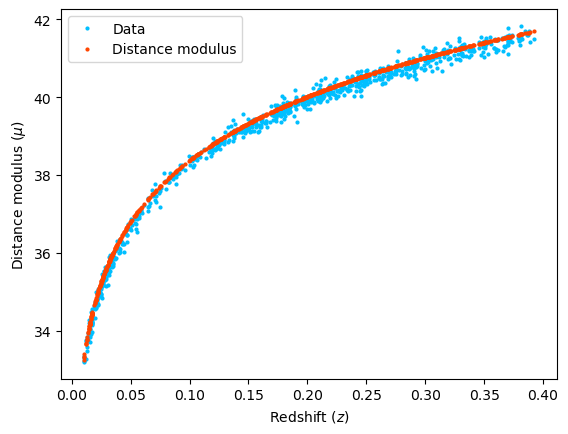

In [309]:
z_data_low=[]
mu_data_low=[]
dmb_low=[]
for i in range(len(z_data)):
    if z_data[i]<0.4:
        z_data_low.append(z_data[i])
        mu_data_low.append(mu_data[i])
        dmb_low.append(dmb[i])

z_data_low=np.array(z_data_low)
mu_data_low=np.array(mu_data_low)
dmb_low=np.array(dmb_low)

Sigma_low = np.diag(dmb_low**2)
Sigma_inv_low = np.linalg.inv(Sigma_low)

plt.plot(z_data_low,mu_data_low,'o',markersize=2,color='deepskyblue',label='Data')
plt.plot(z_data_low,get_mu(z_data_low,68,0.319,0,-1,0),'o',markersize=2,color='orangered',label='Distance modulus')
plt.xlabel('Redshift ($z$)')
plt.ylabel('Distance modulus ($\mu$)')
plt.legend()
plt.show()

### Prior

In [310]:
def log_prior(params):
    Omega_m, w0, wa = params
    if 0.2 < Omega_m < 0.5 and -2 < w0 < 0 and -2 < wa < 2:
        return 0
    return -np.inf

### Likelihood

In [311]:
def log_likelihood(params,z,d,cov_inv):
    Omega_m,w0,wa=params
    if Omega_m<0:
        #print(f"Omega_m out of bounds: {Omega_m}")
        return -np.inf
    mu=get_mu(z,H0,Omega_r,Omega_m,w0,wa)
    diff=d-mu
    term1 = -0.5 * diff @ cov_inv @ diff
    term2 = 0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    return term1 + term2

### Posterior

In [312]:
def log_posterior(params,z,d,cov_inv):
    prior = log_prior(params)
    if np.isfinite(prior):
        return prior + log_likelihood(params,z,d,cov_inv)
    return prior

### $\chi ^2$

In [313]:
def chi(params,z,d,cov_inv):
    return -2*log_posterior(params,z,d,cov_inv)

## Parameter Optimization

In [314]:
initial_guess = [0.319, -1, 0]

result = minimize(chi, initial_guess, args=(z_data_low, mu_data_low, Sigma_inv_low), method='Powell')
best_fit_params = result.x

mu_model_best = get_mu(z_data_low, H0, Omega_r, *best_fit_params)

/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2577: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)
/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2578: RuntimeWarning: invalid value encountered in scalar subtract
  p = (x - v) * tmp2 - (x - w) * tmp1


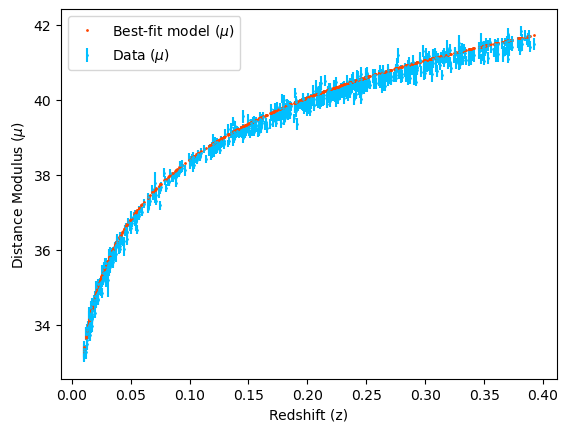

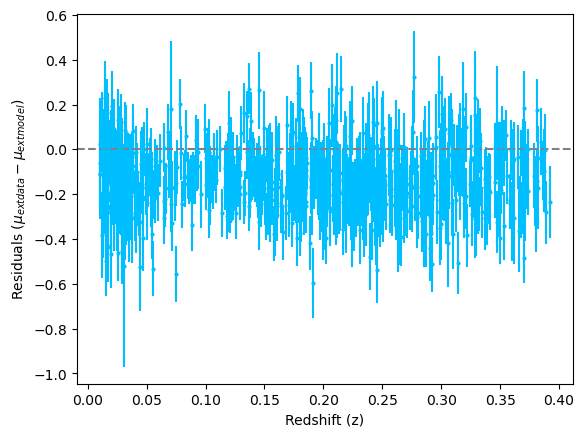

--------------------------------------
Best-fit parameters:
Omega_m: 0.2000000000024226
w0: -1.2700611397933284
wa: 1.9999203167461275
--------------------------------------
Chi-square: 778.3327091765999
Degrees of freedom: 763
Reduced chi-square: 1.0200952938094363
--------------------------------------


In [315]:
plt.errorbar(z_data_low, mu_data_low, yerr=dmb_low, fmt='o', markersize=1, color='deepskyblue', label='Data ($\mu$)')
plt.plot(z_data_low, mu_model_best, 'o', markersize=1, color='orangered', label='Best-fit model ($\mu$)')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend()
plt.show()

residuals = mu_data_low - mu_model_best
plt.errorbar(z_data_low, residuals, yerr=dmb_low, fmt='o', markersize=2, color='deepskyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Redshift (z)')
plt.ylabel('Residuals ($\mu_{\text{data}} - \mu_{\text{model}}$)')
plt.show()

print("--------------------------------------")
print("Best-fit parameters:")
print("Omega_m:", best_fit_params[0])
print("w0:", best_fit_params[1])
print("wa:", best_fit_params[2])
print("--------------------------------------")
chi2 = -2 * log_posterior(best_fit_params, z_data_low, mu_data_low, Sigma_inv_low)
print("Chi-square:", chi2)
print("Degrees of freedom:", len(z_data_low) - len(best_fit_params))
print("Reduced chi-square:", chi2 / (len(z_data_low) - len(best_fit_params)))
print("--------------------------------------")

## MCMC

In [316]:
initial = np.array([0.319, -1, 0])
ndim = len(initial)
nwalkers = 50

std_Om0 = 1e-2
std_w0_wa = 1e-1

pos = np.empty((nwalkers, ndim))
pos[:, 0] = initial[0] + std_Om0 * np.random.randn(nwalkers)
pos[:, 1] = initial[1] + std_w0_wa * np.random.randn(nwalkers)
pos[:, 2] = initial[2] + std_w0_wa * np.random.randn(nwalkers)

'''
# Check initial likelihoods
for i in range(nwalkers):
    print(log_likelihood(pos[i], z_data_low, mu_data_low, Sigma_inv_low))

# Check initial posteriors
for i in range(nwalkers):
    print(log_posterior(pos[i], z_data_low, mu_data_low, Sigma_inv_low))
'''

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z_data_low, mu_data_low, Sigma_inv_low))

In [317]:
nsteps = 1000
sampler.run_mcmc(pos, nsteps, progress=True)

samples = sampler.get_chain(discard=200,thin=10,flat=True)

100%|██████████| 1000/1000 [32:34<00:00,  1.95s/it]


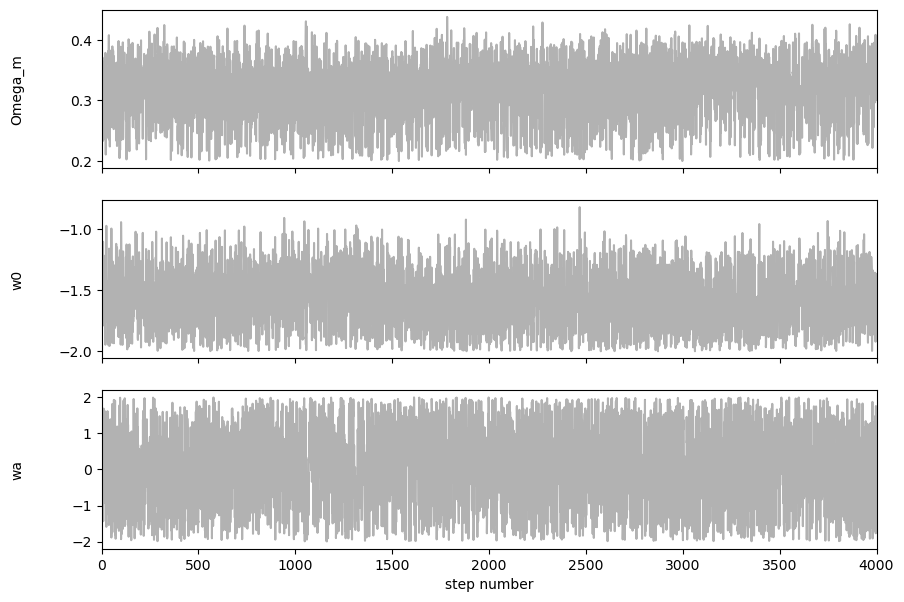

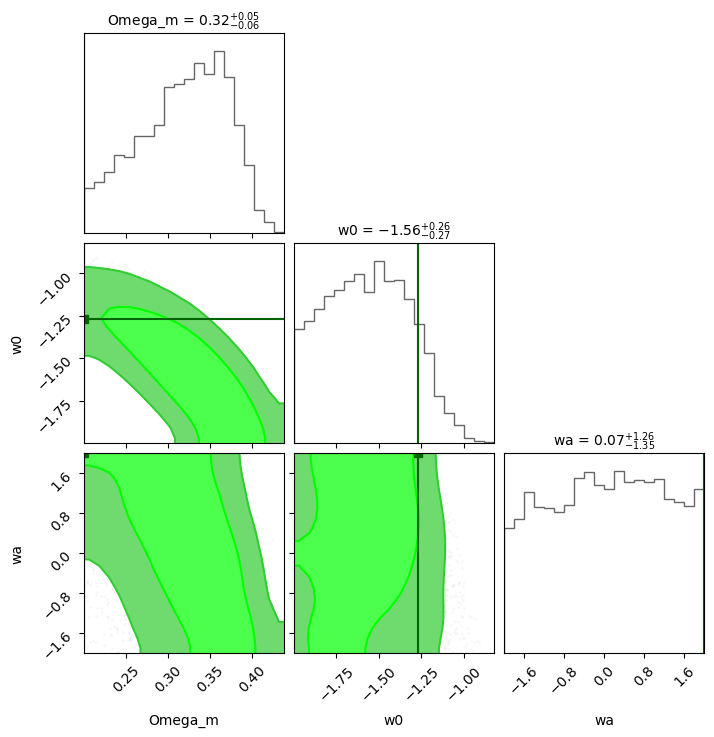

In [318]:
reshaped_samples = samples.reshape(-1, samples.shape[-1])

#plot the chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Omega_m", "w0", "wa"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(reshaped_samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(reshaped_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

level_colors = ['limegreen', 'lime']

contourf_kwargs = {
    "colors": ['white', 'limegreen', 'lime'],
    "alpha": 0.7
}
fig = corner.corner(reshaped_samples,
                    labels=labels,
                    truths=best_fit_params,
                    truth_color='darkgreen',
                    plot_contours=True,
                    fill_contours=True,
                    levels=[0.68, 0.95],
                    smooth=2.0,
                    show_titles=True,
                    title_fmt=".2f",
                    title_kwargs={"fontsize": 10},
                    hist_kwargs={"density": True, "alpha": 0.6},
                    contour_kwargs={"colors": level_colors},
                    contourf_kwargs=contourf_kwargs
                    )
    
plt.show()

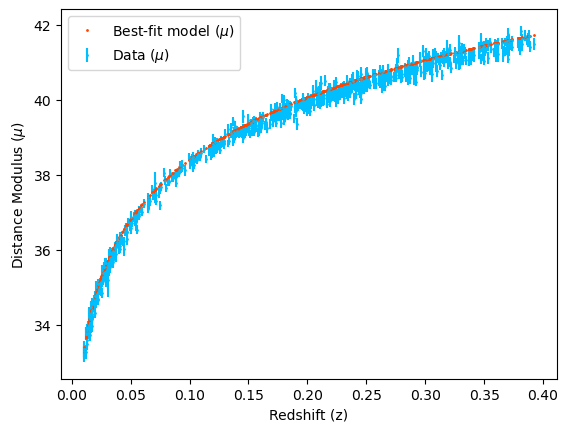

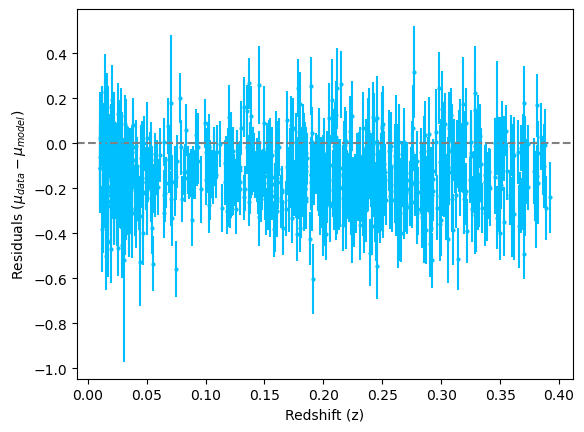

In [319]:
#plot the best fit model
best_fit_params_mcmc = np.mean(reshaped_samples, axis=0)
best_fit_params_mcmc_std = np.std(reshaped_samples, axis=0)
mu_model_best_mcmc = get_mu(z_data_low, H0, Omega_r, *best_fit_params_mcmc)

plt.errorbar(z_data_low, mu_data_low, yerr=dmb_low, fmt='o', markersize=1, color='deepskyblue', label='Data ($\mu$)')
plt.plot(z_data_low, mu_model_best_mcmc, 'o', markersize=1, color='orangered', label='Best-fit model ($\mu$)')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend()
plt.show()

#plot the residuals
residuals_mcmc = mu_data_low - mu_model_best_mcmc
plt.errorbar(z_data_low, residuals_mcmc, yerr=dmb_low, fmt='o', markersize=2, color='deepskyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Redshift (z)')
plt.ylabel('Residuals ($\mu_{data} - \mu_{model}$)')
plt.show()

In [320]:
print("--------------------------------------")
print("Best-fit parameters (MCMC):")
print("Omega_m:", best_fit_params_mcmc[0], "+/-", best_fit_params_mcmc_std[0])
print("w0:", best_fit_params_mcmc[1], "+/-", best_fit_params_mcmc_std[1])
print("wa:", best_fit_params_mcmc[2], "+/-", best_fit_params_mcmc_std[2])
print("--------------------------------------")

--------------------------------------
Best-fit parameters (MCMC):
Omega_m: 0.31765892953119185 +/- 0.051270792509291056
w0: -1.564061145764702 +/- 0.24024736115926387
wa: 0.05217870101638888 +/- 1.120364437453657
--------------------------------------


### Statistics

In [321]:
samples_Omega_m = reshaped_samples[:, 0]
samples_w0 = reshaped_samples[:, 1]
samples_wa = reshaped_samples[:, 2]

samples_dict = {
    "Omega_m": samples_Omega_m,
    "w0": samples_w0,
    "wa": samples_wa
}

for key, value in samples_dict.items():
    print(f"Mean of {key}: {np.mean(value)}")
    print(f"Standard deviation of {key}: {np.std(value)}")
    print(f"Median of {key}: {np.median(value)}")
    print(f"68% credible interval of {key}: {np.percentile(value, [16, 84])}")
    print(f"95% credible interval of {key}: {np.percentile(value, [2.5, 97.5])}")
    print(f"Skewness of {key}: {stats.skew(value)}")
    print(f"Kurtosis of {key}: {stats.kurtosis(value)}")
    print("--------------------------------------")

Mean of Omega_m: 0.31765892953119046
Standard deviation of Omega_m: 0.05127079250929108
Median of Omega_m: 0.32343623685227363
68% credible interval of Omega_m: [0.25952489 0.37057287]
95% credible interval of Omega_m: [0.21258766 0.39799915]
Skewness of Omega_m: -0.3528636977474155
Kurtosis of Omega_m: -0.7099853648443655
--------------------------------------
Mean of w0: -1.5640611457647013
Standard deviation of w0: 0.24024736115926384
Median of w0: -1.5643498810297367
68% credible interval of w0: [-1.83403839 -1.30368498]
95% credible interval of w0: [-1.97408741 -1.10974771]
Skewness of w0: 0.10452959336497533
Kurtosis of w0: -0.8402120734574177
--------------------------------------
Mean of wa: 0.05217870101638871
Standard deviation of wa: 1.1203644374536574
Median of wa: 0.07476727528526877
68% credible interval of wa: [-1.27561465  1.33226206]
95% credible interval of wa: [-1.88024053  1.91976005]
Skewness of wa: -0.05074058926864367
Kurtosis of wa: -1.12085438630106
-----------

**N.B.:**

* positive skewness: the distribution has a long tail on the right side;
* negative skewness: the distribution has a long tail on the left side;
* kurtosis > 0: the distribution has heavy tails and a sharp peak, indicating a higher likelihood of extreme values;
* kurtosis < 0: the distribution has light tails and a flatter peak, indicating a lower likelihood of extreme values.